# PreeSee Data Analysis Project 2022
Team Members: Niv Alterman, Snir Zelig, Sol Ben Zeev, Naama Goldbart


## Main Agenda
In this task we aim to create different decision trees, each time dropping a test and try to classify correctly the overall score of a person. We chose the <strong>Classification</strong> model to produce a grouping of data points (patients) with the purpose of
predicting the label.

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics 

import os
import pydotplus
from IPython.display import Image

### PART 1: Preparing and Cleaning the Data

In [101]:
df = pd.read_excel("data/PreSee.xlsx")

def objects_to_nums(df):
    df['gender'] = df['gender'].map({'Male':1, 'Female':0}).astype(int)
    df['smoking'] = df['smoking'].map({'YES':1, 'NO':0})
    df['heart_disease_hist'] = df['heart_disease_hist'].map({'YES':1, 'NO':0})
    df['heart_disease_family_hist'] = df['heart_disease_family_hist'].map({'YES':1, 'NO':0})
    df['bp_medication'] = df['bp_medication'].map({'YES':1, 'NO':0})
    df['diabetes'] = df['diabetes'].map({'YES':1, 'NO':0})
    df["work_stress_level"] = df["work_stress_level"].map({'0/5':0, '1/5':0.2, '2/5':0.4, '3/5':0.6, '4/5':0.8, '5/5':1})
    df["exercise_level"] = df["exercise_level"].map({'0/5':0, '1/5':0.2, '2/5':0.4, '3/5':0.6, '4/5':0.8, '5/5':1})
    return df

df = objects_to_nums(df)

Dataset has 23 rows of null/5 that been dropped

In [102]:
df = df.dropna()

After data observation at overall score distribution (see below graphs) we saw that dividing to 4 groups of risk forecasted is a good choice. It will help our model to classify a person to a group instead to a wide numerical values (0-100). Our model is mistaken if a new person is classified to a wrong group.

In [103]:
# the 4 bins (the higher the better\healthier)
df_class_names = ['VeryLowScore', "LowScore", "HighScore",'VeryHighScore']
def split_to_label(df):
    
    if df['overall_score'] <= 90:
        return 'VeryLowScore'
    elif (df['overall_score'] <= 94) and (df['overall_score'] > 90):
        return 'LowScore'
    elif (df['overall_score'] <= 95) and (df['overall_score'] > 94):
        return 'HighScore'
    else:
        return 'VeryHighScore'
df['label'] = df.apply(split_to_label, axis=1)

In [104]:
# remove unwanted features that may affect the model (known high correlation and unique values)
def drop_general_columns(df):
    df = df.drop(['patient_id','ecg_weight','us_weight','blood_weight','personal_weight'], axis = 1)
    return df

df = drop_general_columns(df)

In [105]:
# make the overall score as our target value of the tree
def move_overall_score_to_last_column(df):
    columns = []
    for column in df.columns:
        if column != 'overall_score':
            columns.append(column)
    columns.append('overall_score')
    df = df[columns]
    return(df)
df = move_overall_score_to_last_column(df)

In [106]:
# functions to remove a specific company's test for later usage.
def drop_blood(df):
    return df.drop(['blood_test_score'], axis = 1)

def drop_ecg(df):
    return df.drop(['ecg_test_score'], axis = 1)

def drop_us(df):
    return df.drop(['us_test_score'], axis = 1)

In [107]:
def get_predictors_names(dataframe):
    names = list(dataframe.columns)
    predictors_names=names[:-2]
    return predictors_names
df_predictors_names = get_predictors_names(df)
df_predictors_names

['gender',
 'age',
 'height_cm',
 'weight_kg',
 'bmi',
 'ecg_test_score',
 'us_test_score',
 'blood_test_score',
 'personal_score',
 'smoking',
 'heart_disease_hist',
 'heart_disease_family_hist',
 'bp_medication',
 'diabetes',
 'work_stress_level',
 'exercise_level',
 'bp_systolic',
 'bp_diastolic']

### PART 2: Explore The Data

In [108]:
# Define a function to explore the data
def plot_properties (dataframe):
    print('head\n',dataframe.head(5))
    print('columns\n',dataframe.columns)
    print('shape\n', dataframe.shape)
    print('info\n', dataframe.info())
    print('describe\n', dataframe.describe())

# Call the function
plot_properties(df)

head
    gender  age  height_cm  weight_kg  bmi  ecg_test_score  us_test_score  \
0       0   41        170         52   18             100            100   
1       1   26        173         60   20             100            100   
2       1   38        172         65   22             100            100   
3       0   39        160         67   26             100            100   
4       1   33        176         79   26             100            100   

   blood_test_score  personal_score  smoking  heart_disease_hist  \
0                98              94        0                   0   
1                90              67        1                   0   
2                84              82        1                   0   
3                91              91        0                   0   
4                67              94        0                   0   

   heart_disease_family_hist  bp_medication  diabetes  work_stress_level  \
0                          0              0         

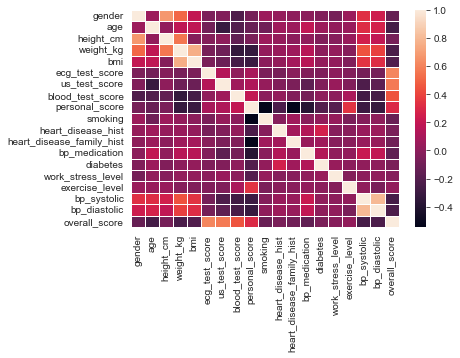

In [109]:
# Define a function to plot the correlation between variables
def plot_corr(dataframe):
    corr = dataframe.corr()
    sns.heatmap(corr, annot=False, linewidths=1)
    plt.show()

# Call the function
plot_corr(df)

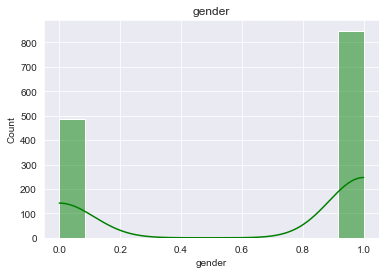

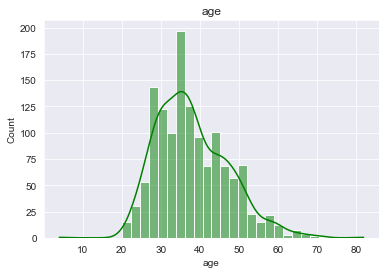

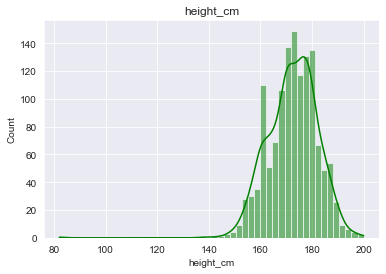

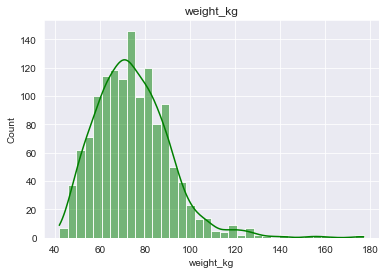

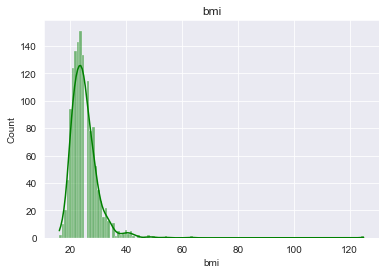

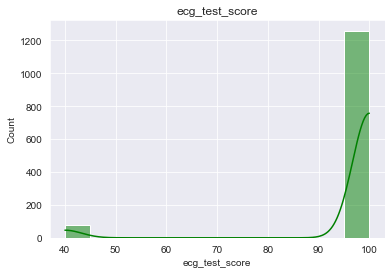

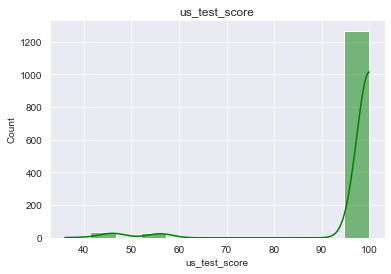

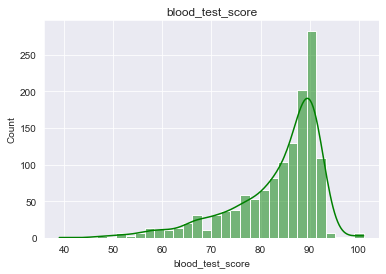

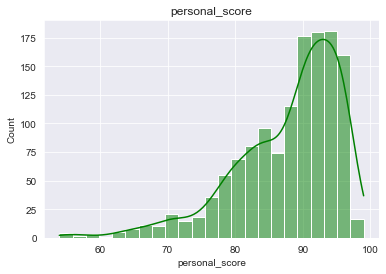

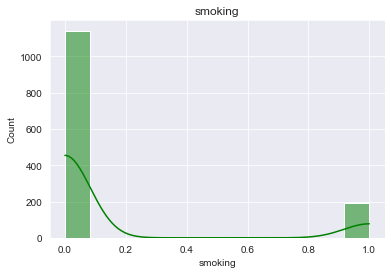

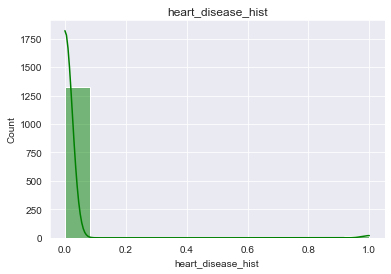

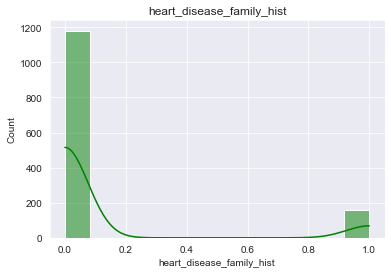

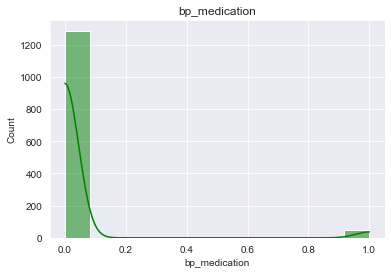

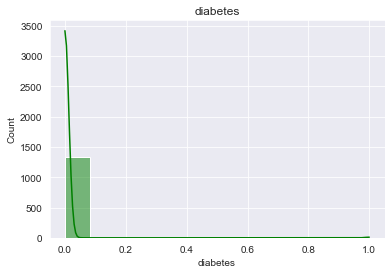

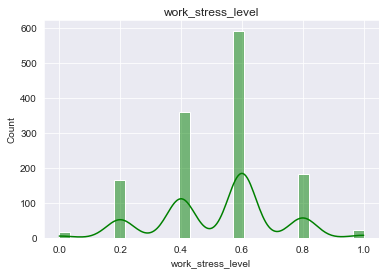

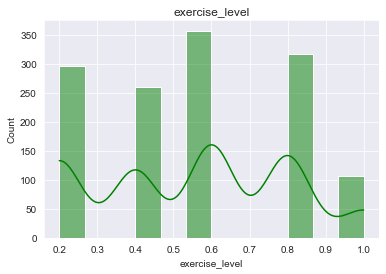

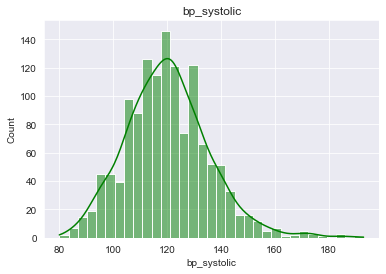

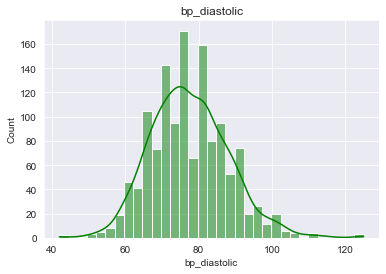

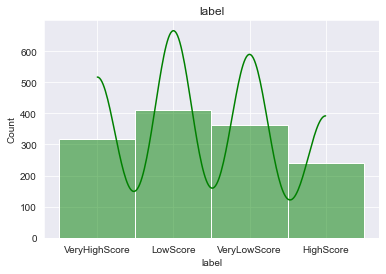

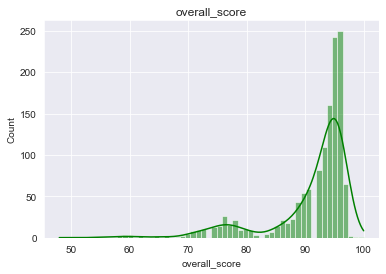

In [110]:
# plot the distribution of variables
def plot_dist(dataframe):
    for feature in dataframe.columns:
        sns.histplot(dataframe[feature], kde=True, color='g')
        # name the graph with the feature name
        plt.title(feature)
        plt.show()
# call the function to plot the distribution of variables
plot_dist(df)

### PART 3: DEFINE FUNCTIONS FOR DECISION TREE MODEL

(1) Saving data in array

In [111]:

def get_nd(dataframe):
    nd = dataframe.values
    return nd
# nd_test = get_nd(test)
# nd_train = get_nd(train)

(2) Split array into train and test - will perform inside function

In [112]:
# split train and test using random state to create the same train and test split in each case we make. (the same pseudo-random values will be generated)

# train, test = train_test_split(current_df, test_size=0.2, random_state=42)

(3) predictors label separations X include the predictors columns Y is the label column

In [113]:
def get_XY(ndarray):
    X=ndarray[:,:-2]
    Y= ndarray[:,-2]
    return X,Y
# X_train,Y_train = get_XY(nd_train)
# X_test,Y_test = get_XY(nd_test)

(4) Build model with training data

In [114]:
def get_clf(X,Y):
    clf = DecisionTreeClassifier(criterion="entropy",  min_impurity_decrease=0.01)
    clf.fit(X, Y)
    return clf
# clf=get_clf(X_train,Y_train)

(5) Make predictions for testing data

In [115]:
def get_pred(classifier, X):
    y_pred = classifier.predict(X)
    return(y_pred)
# y_pred = get_pred(clf, X_test)

(6) calculate Accuracy, frequency of cases when the classifier is correct

In [116]:
def get_accuracy(test,pred): 
    accuracy = metrics.accuracy_score(test, pred)
    return accuracy
# clf_accuracy=get_accuracy(Y_test,y_pred)
# print(clf_accuracy)

(7) Generate a graph

In [117]:
def get_graph(clf,df_predictors_names):
    dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=df_predictors_names,  
                                class_names=df_class_names)
    graph = pydotplus.graph_from_dot_data(dot_data) 
    return graph
# graph = get_graph(clf,df_predictors_names)

def get_image(graph):
    image=Image(graph.create_png())
    return image
# image = get_image(graph)
# image

In [118]:
# this function will get a dataframe without a test, will train a model an evaluate the outcome
def train_and_evaluate(test_dropped_name, current_df):
    """
    :param test_dropped_name: the test that is missing
    :param current_df: dataset without the test
    """
    train, test = train_test_split(current_df, test_size=0.2, random_state=41)
    nd_test = get_nd(test)
    nd_train = get_nd(train)
    X_train,Y_train = get_XY(nd_train)
    X_test,Y_test = get_XY(nd_test)
    clf=get_clf(X_train,Y_train)
    y_pred = get_pred(clf, X_test)
    clf_accuracy=get_accuracy(Y_test,y_pred)
    only_or_both = "ONLY"
    if "and" in test_dropped_name:
        only_or_both = "BOTH"
    print(f' Accuracy of the decision tree based on data when {only_or_both} the {test_dropped_name} is missing is: {clf_accuracy}')

In [119]:
# create missing test different dataset and save it in dictionary
df_no_us_test = drop_us(df)
df_no_ecg_test = drop_ecg(df)
df_no_blood_test = drop_blood(df)
df_no_us_and_ecg = drop_ecg(drop_us(df))
dfs_dict = {"Blood Test" : df_no_blood_test,
            "Ultrasound Test" : df_no_us_test,
            "ECG Test" : df_no_ecg_test,
            "ECG and Ultrasound Tests": df_no_us_and_ecg }

### PART 4: Building a model for each missing test and evaluate its accuracy

In [120]:
for df_without_test_name in dfs_dict:
    train_and_evaluate(df_without_test_name, dfs_dict[df_without_test_name])

 Accuracy of the decision tree based on data when ONLY the Blood Test is missing is: 0.503731343283582
 Accuracy of the decision tree based on data when ONLY the Ultrasound Test is missing is: 0.8805970149253731
 Accuracy of the decision tree based on data when ONLY the ECG Test is missing is: 0.8880597014925373
 Accuracy of the decision tree based on data when BOTH the ECG and Ultrasound Tests is missing is: 0.8694029850746269


#### CONCLUSION: From here we can conclude that the Blood test is the most essential test to perform, and the existence of blood test score among one of the others seem to be a good group seperator.
more is on the attached report
